In [1026]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import missingno as msno
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### 결측치 점검

In [1027]:
df_raw = pd.read_csv('C:\\Users\\user\\Downloads\\0822_H_data.csv')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 254 entries, id to hm_01_rel_t
dtypes: float64(178), int64(74), object(2)
memory usage: 29.0+ MB


In [1028]:
df = df_raw.drop(['emp_keep_a', 'hazard_phy_d','hazard_phy_a','hazard_phy_c','hazard_phy_e','hazard_phy_f','hazard_phy_g','hazard_phy_h', 'hazard_phy_i', 'ch_downsizing', 'job_c1_r', 'job_c1', 'emp_pay_type', 'skillmat', 'emp_comp_com_a','emp_comp_com_b','emp_comp_com_c','ch_ic','ch_restruct','wplace_sl','emp_noncon', 'wcomback'], axis = 1)

In [1029]:
# 널값 개수와 비율 계산
null_summary = (
    df.isnull().sum()
      .to_frame("널값 개수")
      .assign(널값비율 = lambda x: (x["널값 개수"] / len(df_raw) * 100).round(2))
      .reset_index()
      .rename(columns={'index': '컬럼명'})
)

# 널값 있는 열만 필터링 & 비율 기준 내림차순 정렬
null_summary = (
    null_summary[null_summary["널값 개수"] > 0]
    .sort_values(by="널값비율", ascending=False)
    .reset_index(drop=True)
)

print(null_summary)

                  컬럼명  널값 개수  널값비율
0         comp_size_b    870  5.82
1        wtime_ftwork    584  3.90
2            emp_keep    581  3.88
3          emo_manual    307  2.05
4    wtime_resilience    279  1.87
..                ...    ...   ...
150       wsituation7      2  0.01
151      wsituation13      1  0.01
152            wstat1      1  0.01
153         winten2_a      2  0.01
154     wtime_length3      2  0.01

[155 rows x 3 columns]


In [1030]:
# start 파일
# df.to_csv("2PD_v1_0822.csv", encoding="CP949")

### 중복 피쳐 삭제/8,9->결측치 수정

In [1031]:
# 불필요한 피쳐 삭제하기 (14개)
df = df.drop(columns=["ptime_r", "stratification", "district", "household", "target", "mode", "hh_num", "eli_num", "hm_01_gender", "hm_01_year", "hm_01_estat", "hm_01_rel_t","wtime_week", "earning1_r"])

print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  edu  marital  children  \
0               6     40.0            1  ...  5.0      1.0     

In [1032]:
# 전처리: 8, 9 NULL (5개)
cols = ["hazard_erg_a", "hazard_erg_b", "hazard_erg_c", "hazard_erg_d", "hazard_erg_e"]

df[cols] = df[cols].replace([8, 9], pd.NA)

print(df['hazard_erg_a'].unique())
print(df['hazard_erg_b'].unique())
print(df['hazard_erg_c'].unique())
print(df['hazard_erg_d'].unique())
print(df['hazard_erg_e'].unique())


[6 2 1 7 5 4 3 <NA>]
[1 5 6 3 4 7 2 <NA>]
[ 7.  6.  2.  5.  4.  3.  1. nan]
[ 7.  2.  5.  4.  6.  3. nan  1.]
[ 7.  3.  5.  6.  4.  2.  1. nan]


In [1033]:
# 잘못 변경된 변수명 복원
df.rename(columns={
    "wsituation": "wsituation8",
    "wsituation.1": "wsituation9",
    "disc": "disc9",
    "disc.1": "disc8"
}, inplace=True)

### 긍/부정 변경

In [1034]:
df["wstat4"].head(10) 

0    2
1    2
2    2
3    3
4    5
5    5
6    5
7    5
8    5
9    5
Name: wstat4, dtype: int64

In [1035]:
# 긍/부정 변경
# 5점 척도

cols = [
    "wstat4", "wstat6",
    "wwa1", "wwa2", "wwa3", "wwa4", "wwa5",
    "sleep1", "sleep2", "sleep3",
    "imte1", "imte2", "imte3", "imte4", "imte5",
    "wsituation12", "wsituation14"
]

# 변환 딕셔너리 (5점 척도 역코딩)
reverse_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])

df["wstat4"].head(10) 

0    4
1    4
2    4
3    3
4    1
5    1
6    1
7    1
8    1
9    1
Name: wstat4, dtype: int64

In [1036]:
# 3점 척도 
cols_2 = [
   "heal_lim1"
]

# 변환 딕셔너리 (3점 척도 역코딩)
reverse_map = {1: 3, 2: 2, 3: 1}

# 여러 열에 적용
for col in cols_2:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_2].head())
#%%
df["heal_lim1"].head(10) 
#%%


['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: heal_lim1, dtype: float64

In [1037]:
# 4점 척도
cols_1 = [
    "imte1", "imte2", "imte3", "imte4", "imte5",
]

# 변환 딕셔너리 (4점 척도 역코딩)
reverse_map = {1: 4, 2: 3, 3: 2, 4: 1}

# 여러 열에 적용
for col in cols_1:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_1].head())
#%%
df["imte1"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    3.0
4    2.0
5    2.0
6    2.0
7    1.0
8    2.0
9    2.0
Name: imte1, dtype: float64

### 연속형 변수 재범주화

In [1038]:
df['heal_abs1'].value_counts()

heal_abs1
0.0      14127
2.0        181
1.0        127
3.0        113
5.0         80
7.0         65
10.0        31
8.0         25
4.0         24
6.0         10
15.0         9
20.0         6
30.0         6
14.0         5
13.0         5
12.0         4
90.0         3
60.0         2
11.0         1
180.0        1
120.0        1
50.0         1
21.0         1
Name: count, dtype: int64

In [1039]:
# 범주화 

df["heal_abs1_group"] = np.where(df["heal_abs1"] == 0, 0, 1)
df['heal_abs1_group'] = df['heal_abs1_group'].map({0: 1, 1: 2})
#%%
print(df["heal_abs1_group"].head())
#%%
df["heal_abs1_group"].value_counts()


0    1
1    1
2    1
3    1
4    1
Name: heal_abs1_group, dtype: int64


heal_abs1_group
1    14127
2      829
Name: count, dtype: int64

In [1040]:
# 구간 (0~60, 61~120, 121 이상)
bins = [0, 60, 120, float("inf")]
labels = [1, 2, 3]

df["ctime_group"] = pd.cut(df["ctime"], bins=bins, labels=labels, right=True)
#%%
print(df["ctime_group"].head())
#%%
df["ctime_group"].value_counts()
#%%

0      1
1      1
2      1
3      2
4    NaN
Name: ctime_group, dtype: category
Categories (3, int64): [1 < 2 < 3]


ctime_group
1    12582
2     1150
3      328
Name: count, dtype: int64

In [1041]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['heal_abs1','ctime'], axis = 1)
print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  children  panel_survey  ind  \
0               6     40.0            1  ...       1.0    

### 중복 피쳐 삭제

In [1042]:
# 1차 프로젝트에서 파생변수 만들었던 변수 삭제
df = df.drop(['occ', 'occ2', 'age', 'earning2_r', 'wday_week', 'woutside4', 'wtime_r', 'wduration_y'], axis = 1)

### 상관관계 매트릭스 분석

In [1043]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
# sns.heatmap(corr, cmap="coolwarm", center=0)
# plt.show()

In [1044]:
# 상관계수 절댓값이 0.8 이상인 쌍만 추출 (자기 자신 제외)
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
        .stack()                                               
        .reset_index()
        .rename(columns={'level_0': '변수1', 'level_1': '변수2', 0: '상관계수'})
)

# 조건 필터링
high_corr = high_corr[high_corr['상관계수'].abs() >= 0.8]

print(high_corr.sort_values(by='상관계수', ascending=False).head(20))

                    변수1           변수2      상관계수
10060       comp_size_b  comp_sizeb_r  1.000000
10059       comp_size_b  comp_sizea_r  1.000000
15552             disc3         disc4  0.988628
20492               ind          ind2  0.985571
15452             disc2         disc3  0.984493
15453             disc2         disc4  0.982562
1780     compsize_group  comp_sizeb_r  0.975227
1636     compsize_group   comp_size_b  0.969841
15351             disc8         disc2  0.962101
15353             disc8         disc4  0.956305
15352             disc8         disc3  0.954483
15249             disc7         disc8  0.944109
15250             disc7         disc2  0.920967
20499      comp_sizea_r  comp_sizeb_r  0.920086
2165   compsize_group_a  comp_sizeb_r  0.916659
15252             disc7         disc4  0.913893
15251             disc7         disc3  0.913422
1779     compsize_group  comp_sizea_r  0.910546
2021   compsize_group_a   comp_size_b  0.893071
15146             disc6         disc7  0

In [1045]:
unique_vars = set(high_corr['변수1']).union(set(high_corr['변수2']))
print("조건 충족하는 변수 개수:", len(unique_vars))
print("변수 목록:", unique_vars)

조건 충족하는 변수 개수: 23
변수 목록: {'disc2', 'comp_sizea_r', 'compsize_group', 'disc6', 'woutside_group', 'ind', 'earning1', 'earning2_group_b', 'winten2_b', 'comp_size_b', 'disc3', 'disc7', 'decla_b', 'decla_a', 'woutside4_a', 'disc8', 'winten3_c', 'disc4', 'winten2_a', 'winten3_d', 'ind2', 'compsize_group_a', 'comp_sizeb_r'}


In [1046]:
# 상관분석 결과 필요없는 변수 삭제
df = df.drop(['comp_size_b', 'comp_sizea_r', 'comp_sizeb_r', 'ind', 'ind2', 'earning1', 'woutside4_a'], axis = 1)

In [1047]:
# disc 변수 : 차별 유/무로 파생변수 생성
cols = ['disc1','disc2','disc3','disc4','disc5',
        'disc6','disc7','disc8','disc9','disc10','disc11']

# 하나라도 1이 있으면 1, 아니면 0
df['disc_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['disc_group'] = df['disc_group'].map({0: 1, 1: 2})

print(df['disc_group'].unique())

[2 1]


In [1048]:
# decla 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['decla_a','decla_b']

# 하나라도 1이 있으면 1, 아니면 0
df['decla_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['decla_group'] = df['decla_group'].map({0: 1, 1: 2})

print(df['decla_group'].unique())

[2 1]


In [1049]:
# winten2 변수 : 작업 강도가 세다로 파생변수 생성(7점 척도)
cols = ['winten2_a','winten2_b']

# 둘 중 하나라도 있으면 최대값
df['winten2_group'] = df[cols].max(axis=1, skipna=True)

print(df['winten2_group'].unique())

[ 5.  6.  7.  1.  4.  3.  2. nan]


In [1050]:
# winten3 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e']

# 하나라도 1이 있으면 1, 아니면 0
df['winten3_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['winten3_group'] = df['winten3_group'].map({0: 1, 1: 2})

print(df['winten3_group'].unique())

[2 1]


In [1051]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['disc1','disc2','disc3','disc4','disc5',
              'disc6','disc7','disc8','disc9','disc10','disc11','decla_a','decla_b','winten2_a','winten2_b', 'winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e'], axis = 1)

### 조작적 정의에 사용된 변수 삭제

In [1052]:
df = df.drop(['weng1','weng2','weng3','wsituation14','wwa2','sleep2','sleep3','weng4','weng5','wsituation1','wstat4','wsituation2','wsituation12', 'wsituation10','wsituation9', 'emp_manaqual_a'], axis = 1)

### 널값 삭제

In [1053]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 171 entries, id to winten3_group
dtypes: category(1), float64(133), int64(33), object(4)
memory usage: 19.4+ MB


In [1054]:
df_new = df.dropna()

In [1055]:
df_new

,id,burnout60,area,gender,wtime_length5,age_group,emp_period_group,wtime_group,compsize_group,woutside_group,...,edu,marital,children,panel_survey,heal_abs1_group,ctime_group,disc_group,decla_group,winten2_group,winten3_group
0,1000042_1,lv1,1,1,2,4,5,2,4,0,...,5.0,1.0,1.0,2,1,1,2,2,5.0,2
1,1000051_1,lv2,1,1,2,3,2,2,11,0,...,6.0,2.0,2.0,2,1,1,2,2,6.0,2
2,1000056_1,lv1,1,1,2,3,2,2,1,0,...,5.0,2.0,2.0,2,1,1,2,2,5.0,2
3,1000069_1,lv1,1,1,2,3,2,2,10,0,...,6.0,1.0,1.0,2,1,2,2,2,7.0,2
5,1000077_1,lv1,1,1,2,3,2,2,10,0,...,6.0,1.0,2.0,2,1,1,2,2,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14949,2009922_1,lv1,13,1,1,3,5,2,12,1,...,6.0,2.0,2.0,2,1,1,2,2,4.0,2
14952,2010133_1,lv2,7,2,2,4,3,2,4,0,...,5.0,2.0,2.0,2,1,1,2,2,4.0,2
14953,2010134_2,lv1,7,2,2,3,4,2,4,0,...,6.0,2.0,2.0,2,1,1,2,2,5.0,2
14954,2010137_1,lv1,7,1,2,5,4,2,4,0,...,6.0,1.0,1.0,2,1,1,2,2,5.0,2


### AutoML

In [1056]:
df_new['burnout60'].unique()

array(['lv1', 'lv2', 'lv3'], dtype=object)

In [1057]:
# 타겟 클래스번호 전처리
df_new['burnout60'] = df_new['burnout60'].replace("lv1", 1)
df_new['burnout60'] = df_new['burnout60'].replace("lv2", 2)
df_new['burnout60'] = df_new['burnout60'].replace("lv3", 3)
df_new['burnout60'].unique()

array([1, 2, 3], dtype=int64)

In [1058]:
df_new['burnout60'] = df_new['burnout60'].astype('category')
print(df_new["burnout60"])

0        1
1        2
2        1
3        1
5        1
        ..
14949    1
14952    2
14953    1
14954    1
14955    1
Name: burnout60, Length: 11243, dtype: category
Categories (3, int64): [1, 2, 3]


In [1059]:
# categories.values

In [1060]:
categories = df_new.drop(columns=['id', 'burnout60']).columns

In [1061]:
categories = categories.tolist()

In [1062]:
from pycaret.classification import *
from sklearn.preprocessing import *
# import imblearn
setup_clf = setup(df_new, target = 'burnout60',
                  train_size = 0.8,
                  # ignore_features = ['pclass', 'adult_male', 'deck', 'embark_town', 'alive'],
                  # numeric_features = [],
                  categorical_features = categories,
                  # encoding_method = None,
                #   normalize = True,
                #   normalize_method = 'zscore',
                  # remove_outliers = True,
                #   feature_selection = True,
                  # feature_selection_method = 'classic',
                  # fix_imbalance = True,
                  # fix_imbalance_method = 'SMOTE',
                  fold=5,
                  n_jobs = - 1,
                  session_id = 1234)

,Description,Value
0,Session id,1234
1,Target,burnout60
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(11243, 171)"
5,Transformed data shape,"(11243, 549)"
6,Transformed train set shape,"(8994, 549)"
7,Transformed test set shape,"(2249, 549)"
8,Categorical features,169
9,Preprocess,True


In [1063]:
X_train_transformed = get_config('X_train_transformed')
print(X_train_transformed)

              id  area_15.0  area_9.0  area_1.0  area_2.0  area_5.0  \
13039  1263166_1        1.0       0.0       0.0       0.0       0.0   
8216   1146807_1        0.0       1.0       0.0       0.0       0.0   
1529   1025402_2        0.0       0.0       1.0       0.0       0.0   
1971   1034083_1        0.0       0.0       1.0       0.0       0.0   
2748   1046201_1        0.0       0.0       0.0       1.0       0.0   
...          ...        ...       ...       ...       ...       ...   
12863  1254489_1        0.0       0.0       0.0       0.0       0.0   
6917   1125201_1        0.0       0.0       0.0       0.0       0.0   
5985   1103941_1        0.0       0.0       0.0       0.0       1.0   
12451  1243720_1        0.0       0.0       0.0       0.0       0.0   
10791  1192682_1        0.0       0.0       0.0       0.0       0.0   

       area_10.0  area_12.0  area_3.0  area_17.0  ...  disc_group  \
13039        0.0        0.0       0.0        0.0  ...         1.0   
8216     

In [1064]:
# best = compare_models(fold=10, sort='AUC')

### 변수 중요도 확인

In [1065]:
# 인구통계 컬럼 삭제
df_fe = df_new.drop(['id', 'area', 'gender', 'age_group', 'emp_period_group', 'wtime_group', 'marital', 'children', 'panel_survey', 'edu'], axis = 1)

In [1066]:
# 데이터 타입 변경
df_fe['hazard_erg_a'] = df_fe['hazard_erg_a'].astype('category')
df_fe['hazard_erg_b'] = df_fe['hazard_erg_b'].astype('category')
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11243 entries, 0 to 14955
Columns: 161 entries, burnout60 to winten3_group
dtypes: category(4), float64(130), int64(27)
memory usage: 13.8 MB


In [1067]:
df_fe['burnout60'] = df_fe['burnout60'].astype(int)

In [1068]:
df_fe['burnout60'] = df_fe['burnout60'] - 1

#### 모델만들기

In [968]:
# 전체 데이터
X = df_fe.drop(['burnout60'], axis = 1)
y = df_fe['burnout60']

print("X 데이터: ", X.shape)
print("y 데이터: ", y.shape)

X 데이터:  (11243, 160)
y 데이터:  (11243,)


In [969]:
# 데이터 분할 = 훈련 데이터 / 테스트 데이터 = 7:3
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42)
print("train 데이터: ", X_train.shape)
print("test 데이터: ", X_test.shape)

train 데이터:  (7870, 160)
test 데이터:  (3373, 160)


In [970]:
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score=True,
                        n_jobs = -1, cv = 10)
print(scores)

{'fit_time': array([2.76860714, 2.76860714, 2.78730702, 3.09442019, 2.74957132,
       2.79938698, 2.82864857, 2.82093835, 2.85179234, 2.84778595]), 'score_time': array([0.0166955 , 0.0166955 , 0.01872277, 0.00560236, 0.01444817,
       0.00863743, 0.01062703, 0.00860262, 0.00600839, 0.00600934]), 'test_score': array([0.87928844, 0.85895807, 0.88437103, 0.86658196, 0.87801779,
       0.87547649, 0.88437103, 0.87928844, 0.87801779, 0.8678526 ]), 'train_score': array([0.98898772, 0.9908231 , 0.99124665, 0.99110546, 0.9891289 ,
       0.99124665, 0.99152901, 0.99039955, 0.99237611, 0.99096428])}


In [971]:
# 검증점수, 테스트점수 확인
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9907807426231822 0.8752223634053367


#### 변수중요도 시각화

In [972]:
# 변수중요도 확인

lgb.fit(X_train, y_train)
importances = lgb.booster_.feature_importance(importance_type='gain')
fi = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
fi = fi.sort_values(by='importance', ascending=False)
print(fi.head(20))

            feature   importance
63     wsituation11  2473.139127
66      wsituation8  1445.333536
34   emp_comp_ass_a  1340.415325
60      wsituation3  1252.623858
67     wsituation13  1051.247331
145            who1   971.564894
71           wstat5   904.593138
147            who3   884.763193
65      wsituation7   870.154176
144          sleep1   820.281165
69           wstat2   740.227981
124            wwa3   739.163179
62      wsituation5   682.372214
61      wsituation4   682.162612
30   emp_manaqual_b   594.122489
123            wwa1   502.750617
70           wstat3   495.472940
33   emp_manaqual_e   471.381397
146            who2   465.825713
68           wstat1   444.806320


In [973]:
# 변수중요도 비율로 전환
fi['importance_pct'] = fi['importance'] / fi['importance'].sum() * 100
fi.head(20)

,feature,importance,importance_pct
63,wsituation11,2473.139127,7.573360
66,wsituation8,1445.333536,4.425967
34,emp_comp_ass_a,1340.415325,4.104681
60,wsituation3,1252.623858,3.835842
67,wsituation13,1051.247331,3.219178
145,who1,971.564894,2.975171
71,wstat5,904.593138,2.770087
147,who3,884.763193,2.709362
65,wsituation7,870.154176,2.664626
144,sleep1,820.281165,2.511903


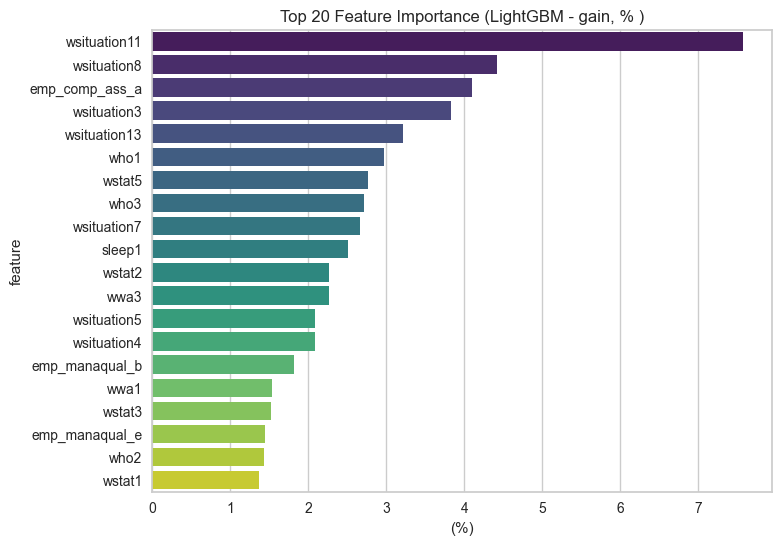

In [974]:
import matplotlib.pyplot as plt
import seaborn as sns

top20 = fi.head(20).copy()

plt.figure(figsize=(8,6))
sns.barplot(
    data=top20,
    x='importance_pct', y='feature', palette='viridis'
)
plt.title("Top 20 Feature Importance (LightGBM - gain, % )")
plt.xlabel("(%)")
plt.show()

### 다시 모델

In [1069]:
# 학습(훈련) 데이터 - 타깃이 있음
train_X = df_fe[~df_fe["burnout60"].isnull()].drop(columns="burnout60").reset_index(drop=True)
train_Y = df_fe[~df_fe["burnout60"].isnull()]['burnout60'].reset_index(drop=True)

# 테스트 데이터 - 타깃이 없음
test_X = df_fe[df_fe["burnout60"].isnull()].drop(columns="burnout60").reset_index(drop=True)

In [1070]:
print(train_X.dtypes)

wtime_length5           int64
compsize_group          int64
woutside_group          int64
compsize_group_a        int64
wday_week_group_a       int64
                       ...   
ctime_group          category
disc_group              int64
decla_group             int64
winten2_group         float64
winten3_group           int64
Length: 160, dtype: object


In [1071]:
# 검증데이터 나누기
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_X, train_Y,
                                                  test_size=0.2,
                                                  stratify = train_Y,
                                                  random_state=1234)
print("train 데이터: ", X_train.shape)
print("val 데이터: ", X_val.shape)

train 데이터:  (8994, 160)
val 데이터:  (2249, 160)


In [1072]:
import lightgbm as lgb
from sklearn.metrics import log_loss, accuracy_score

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

acc = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)

print(f"검증 정확도: {acc:.4f}")
print(f"검증 로그손실: {loss:.4f}")

검증 정확도: 0.8773
검증 로그손실: 0.3078


In [1073]:
# 하이퍼파라미터 설정, 현재는 기본 설정
params = {
    "objective":"multiclass", # binary: 이진분류, regression: 회귀, multiclass: 다중분류
    "num_class": 3,
    "random_seed":1234,
    'verbosity': -1, # 오류 등 메시지 출력 없이 실행
}

In [1074]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

model = lgb.train(
    params=params, # 하이퍼파라미터 지정
    train_set=lgb_train,
    valid_sets=[lgb_val], # 검증 데이터(리스트 형식)
    num_boost_round=1000, # 학습 횟수 = 최대 부스팅 반복 수
    callbacks=[
        lgb.early_stopping(stopping_rounds=5), # 조기 종료 조건 => 5번 연속 성능이 개선되지 않으면 조기 종료
        lgb.log_evaluation(period=1) # 학습 결과의 표시 빈도
    ]
)

[1]	valid_0's multi_logloss: 0.431504
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.412225
[3]	valid_0's multi_logloss: 0.39904
[4]	valid_0's multi_logloss: 0.387671
[5]	valid_0's multi_logloss: 0.37929
[6]	valid_0's multi_logloss: 0.371531
[7]	valid_0's multi_logloss: 0.36435
[8]	valid_0's multi_logloss: 0.358539
[9]	valid_0's multi_logloss: 0.35373
[10]	valid_0's multi_logloss: 0.34955
[11]	valid_0's multi_logloss: 0.345251
[12]	valid_0's multi_logloss: 0.341656
[13]	valid_0's multi_logloss: 0.33817
[14]	valid_0's multi_logloss: 0.335129
[15]	valid_0's multi_logloss: 0.332032
[16]	valid_0's multi_logloss: 0.32995
[17]	valid_0's multi_logloss: 0.326899
[18]	valid_0's multi_logloss: 0.325474
[19]	valid_0's multi_logloss: 0.323679
[20]	valid_0's multi_logloss: 0.322081
[21]	valid_0's multi_logloss: 0.320738
[22]	valid_0's multi_logloss: 0.319076
[23]	valid_0's multi_logloss: 0.317739
[24]	valid_0's multi_logloss: 0.316317
[25]	valid_0's multi

In [1081]:
model.feature_importance(importance_type='gain')

array([3.11241339e+01, 1.70736775e+02, 3.35214996e+00, 0.00000000e+00,
       4.54024601e+01, 6.76671643e+01, 1.04952920e+02, 1.44984639e+02,
       1.99256643e+02, 5.63585076e+01, 2.30959399e+01, 1.36924505e+00,
       0.00000000e+00, 6.54453719e+01, 5.66210794e+00, 3.17623997e+00,
       0.00000000e+00, 2.71198177e+01, 4.48416201e+01, 5.45955588e+01,
       6.60045581e+01, 7.75767257e+01, 5.56123605e+01, 6.32312390e+01,
       6.39351988e+00, 2.45287901e+01, 0.00000000e+00, 2.48283989e+01,
       4.77724981e+00, 3.40556901e+01, 4.62984852e+02, 4.54309287e+02,
       2.20534372e+02, 3.07608979e+02, 1.28628763e+03, 4.43466627e+02,
       3.32693297e+02, 2.34686838e+02, 2.31031413e+02, 1.33510924e+02,
       1.93430502e+01, 2.30864363e+02, 2.55265306e+02, 2.88687232e+02,
       9.13881835e+01, 0.00000000e+00, 8.83820698e+01, 7.66136014e+00,
       7.98872507e+00, 9.93645600e+01, 1.22139048e+02, 4.13512198e+01,
       3.45665073e+01, 8.15176988e+00, 1.95465730e+02, 2.42434422e+02,
      

In [1085]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending = True).tail(20)
importance

# 변수중요도 비율로 전환
importance['importance_pct'] = importance['importance'] / importance['importance'].sum() * 100
importance.head(20)

,importance,importance_pct
wsituation4,435.387061,2.505107
emp_comp_ass_b,443.466627,2.551594
emp_manaqual_c,454.309287,2.613980
wsituation5,460.028482,2.646887
emp_manaqual_b,462.984852,2.663897
who2,505.750138,2.909958
wsituation7,518.632832,2.984082
wwa3,542.706495,3.122595
who3,569.191660,3.274984
wstat3,625.450734,3.598685


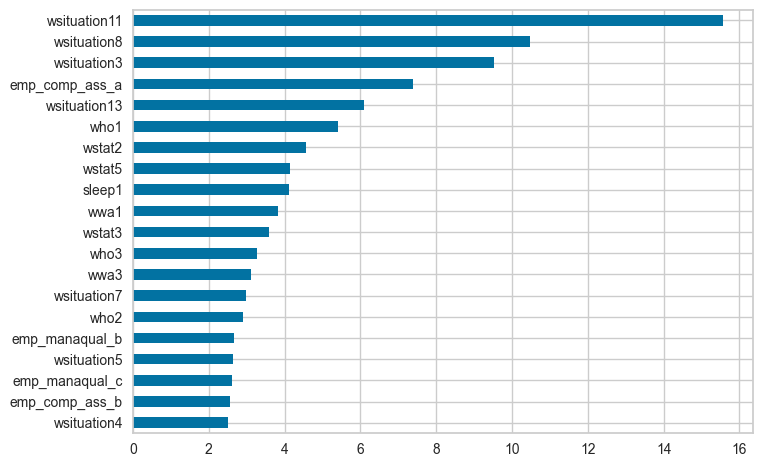

In [1088]:
importance['importance_pct'].plot.barh()
plt.show()

### SHAP 

In [1100]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(train_X)
shap_values

.values =
array([[[ 1.86188049e-04, -3.64971873e-03, -2.74615309e-04],
        [-8.61888593e-03, -7.61161587e-03, -3.77356729e-03],
        [ 0.00000000e+00,  1.06055636e-03,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.34502946e-02, -3.02961385e-03,  1.12138571e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 3.64818996e-04, -1.09106606e-03, -1.46999489e-04],
        [-5.48451909e-03, -4.71215998e-03, -1.07690645e-01],
        [ 0.00000000e+00,  9.28633751e-04,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.44414608e-02,  2.09338975e-02,  3.09211942e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.50689703e-03, -3.74823071e-03, -1.46999489e-04],
        [-4.52847333e-03,  4.05528876e-03,  1.32367499e-02],
        [ 0.00000000e+00,  1.02316133e-03,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.000

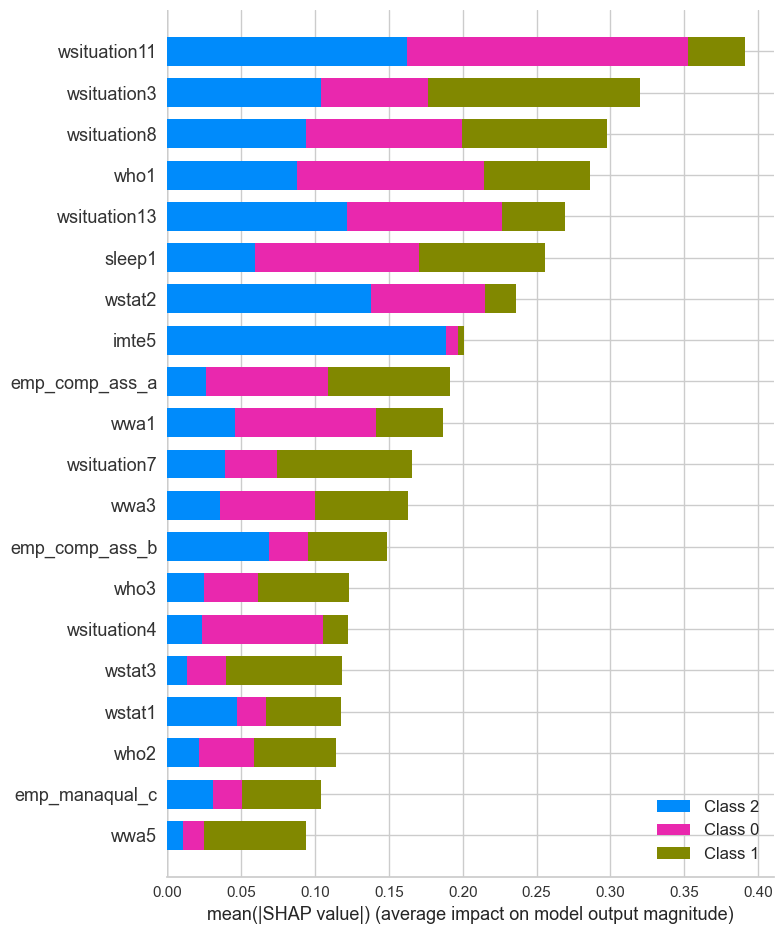

In [1101]:
shap.summary_plot(shap_values, train_X)

In [1104]:
print(type(shap_values))
if isinstance(shap_values, list):
    print("리스트 구조:", [arr.shape for arr in shap_values])
else:
    print("배열 구조:", shap_values.shape)

<class 'shap._explanation.Explanation'>
배열 구조: (11243, 160, 3)


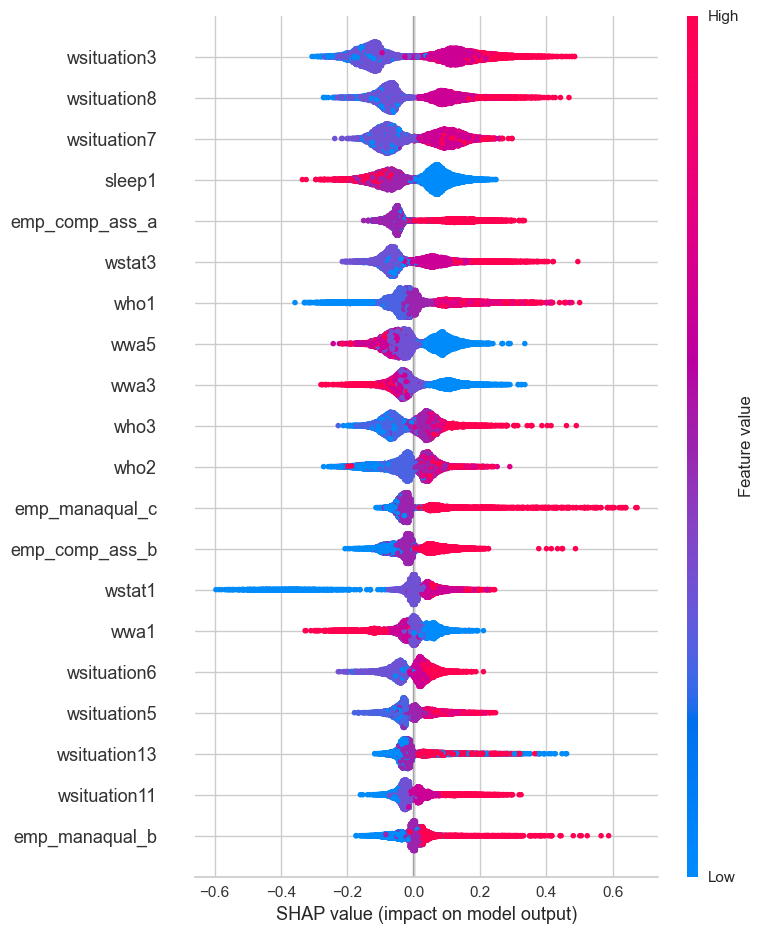

In [1106]:
# 클래스 1만 선택
shap_values_class1 = shap_values[:,:,1]   # (n_samples, n_features)

# summary plot
shap.summary_plot(shap_values_class1, train_X)